In [163]:
import numpy as np
import random 
import matplotlib.pyplot as plt
import copy
from mpl_toolkits import mplot3d
import pandas as pd

In [164]:
real_infected = np.array([100,103,106,113,115,124,141,146,147,177,212,272,322,411,599,721,827,934,1045,1136,1245,1388])
date = np.arange(0,len(real_infected))

In [165]:
############### Parameters ##########################
# Define 7 groups of people depending on how to response
### Normal people = never been infected
# 0 H = (Highy responsible)
# 1 M = (Moderately responsible)
# 2 R = (Risky)
### Infected people = ever been infected
# 3 S = (Spreader)
# 4 P = (Hospital)
# 5 HS = (Healed_Spreader)
# 6 HP = (Healed_Hospital)

f_rate = 0.1

H=30000000
M=10000000
R=20000000
S=real_infected[0]*(1-f_rate)/f_rate
P=real_infected[0]
HS=0
HP=0
SA=S
PA=P

Pop        = [[H],[M],[R],[S],[P],[HS],[HP],[SA],[PA]]
Pop_tot    = H + M + R + S + P + HS + HP
#length     = 20      # predicted length (days)
healed_day = 30   # infected people will be healed in 21 days after being infected

In [166]:
def model(f_rate, meeting, Rh, Rm, Rr, day_i, day_f, population, cf_rate, plot=False, fit=True):
    ## model infection from day_i to day_f and calculate MAE 
    
    # Fitting parameters
    # f_rate      :found rate
    # meeting     :1 infected people can meet <meeting> people
    # {Rh,Rm,Rr}  :transfered rate
    
    R_lst    = [Rh,Rm,Rr]           # transfered rate
    P  = copy.deepcopy(population)  # tempolary list for Population [H,M,R,S,P,C]
    
    if day_i == 0:
        day      = [0]
        day_i = 1
        FRate = [f_rate]*(day_f+1)
    else:
        day   =list(range(day_i))
        FRate = (copy.deepcopy(cf_rate) + [f_rate]*(day_f-day_i+1))
        
    #begin modeling
    for i in range(day_i,day_f+1):
        day.append(i)
        
        ### update healed people
        if i < healed_day:
            new_healed_S = 0
            new_healed_P = 0
        elif i == healed_day:
            new_healed_S = P[7][0]
            new_healed_P = P[8][0]     
        else:
            new_healed_S = P[7][-healed_day]-P[7][-healed_day-1]
            new_healed_P = P[8][-healed_day]-P[8][-healed_day-1]
        P[5].append(P[5][-1] + new_healed_S)
        P[6].append(P[6][-1] + new_healed_P)
        
        ### update normal and infect people
        new_infect = 0
        for j in range(len(R_lst)):
            tmp_infect_group = (meeting*1*R_lst[j]*P[3][-1]*P[j][-1]/Pop_tot)
            new_infect = new_infect + tmp_infect_group
            P[j].append(P[j][-1]- tmp_infect_group)
        
        ### update spreder
        P[3].append(P[3][-1] + new_infect*(1-FRate[i]) - new_healed_S)
        P[7].append(P[7][-1] + new_infect*(1-FRate[i]))
        ### update hospital
        #print(new_healed_P,P[4][-1])
        P[4].append(P[4][-1] + new_infect*FRate[i] - new_healed_P)
        P[8].append(P[8][-1] + new_infect*FRate[i])
        
        
    ### Plotting
    if plot==True:
        P_label = ['Highly_resp','Moderately_resp','Risky','Spreder','Hospital','Spreder_Healed','Hospital_Healed','Spreder_Accumulated','Hospital_Accumulated']
        for i in [4,6]:
            plt.plot(day,P[i],'-',label =P_label[i])
        plt.plot(date,real_infected,'ro', label='real') 
        #plt.ylim([0,P[4][-1]*1.2])
        plt.xlabel('day')
        plt.ylabel('people')
        plt.legend()
        plt.show()
        
        #List = np.array(P[3:7])
        #TI= np.sum(List, 0) 
        #plt.plot(day,TI,'-',label ='Total infected')
        #plt.xlabel('day')
        #plt.ylabel('people')
        #plt.legend()
        #plt.show()
        
    if fit == True:
        ### Calculate MAE
        AE=0
        for i in range(day_i,day_f+1):
            confirmed_case = P[8][i]
            AE=AE+abs(confirmed_case-real_infected[i])
        MAE = AE/(day_f-day_i+1)
        #print("%10.4f" %MAE)

        return MAE, P, FRate
    else:
        return P, FRate

In [167]:
### fitting from day_i to day_f
def fit(f_rate_s,meeting_s,Rh_s,Rm_s,Rr_s,day_i, day_f, CPop, CFRate):
    data = []
    for f_rate in f_rate_s:
        for meeting in meeting_s:
            for Rh in Rh_s:
                for Rm in Rm_s:
                    for Rr in Rr_s:
                        tmp_pop = copy.deepcopy(CPop)
                        tmp_frate = copy.deepcopy(CFRate)
                        MAE, _, _ = model(f_rate, meeting, Rh, Rm, Rr, day_i, day_f,tmp_pop,tmp_frate,plot=False,fit=True)
                        data.append([MAE,f_rate,meeting,Rh,Rm,Rr])
    sorted_data = sorted(data,key=lambda x: x[0])
    print('\nThe top 10 best fitted parameters')
    print('  MAE  f_rate Meeting  Rh    Rm    Rr')
    for i in range(10):
        print('%6.2f %6.2f %4.1f %6.3f %6.3f %6.3f' %(sorted_data[i][0],sorted_data[i][1],sorted_data[i][2],sorted_data[i][3],sorted_data[i][4],sorted_data[i][5]))
    print('\nPlotting for the best fitting')
    print('  MAE  f_rate Meeting  Rh    Rm    Rr')
    print('%6.2f %6.2f %4.1f %6.5f %6.5f %6.5f' %(sorted_data[0][0],sorted_data[0][1],sorted_data[0][2],sorted_data[0][3],sorted_data[0][4],sorted_data[0][5]))
    return sorted_data[0],model(sorted_data[0][1], sorted_data[0][2], sorted_data[0][3], sorted_data[0][4], sorted_data[0][5], day_i, day_f, CPop, CFRate, True, True)


The top 10 best fitted parameters
  MAE  f_rate Meeting  Rh    Rm    Rr
  9.32   0.10 10.0  0.000  0.016  0.010
  9.32   0.10 10.0  0.000  0.006  0.015
  9.32   0.10 10.0  0.000  0.016  0.010
  9.32   0.10 10.0  0.000  0.006  0.015
  9.32   0.10 10.0  0.000  0.016  0.010
  9.32   0.10 10.0  0.000  0.006  0.015
  9.32   0.10 10.0  0.000  0.016  0.010
  9.32   0.10 10.0  0.000  0.006  0.015
  9.32   0.10 10.0  0.000  0.017  0.010
  9.32   0.10 10.0  0.000  0.007  0.015

Plotting for the best fitting
  MAE  f_rate Meeting  Rh    Rm    Rr
  9.32   0.10 10.0 0.00036 0.01600 0.01000


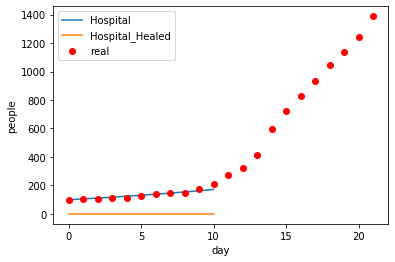

In [182]:
### Fitting
# step 1 day 0 to day 10
day_i = 0; day_f =10
f_rate_s  = [0.1]
meeting_s = [10]                        
Rh_s      = np.arange(0.0001,0.0005,0.00002)
Rm_s      = np.arange(0.001,0.02,0.001)
Rr_s      = np.arange(0.01,0.06,0.005)
params, [MAE, CPop, CFRate] = fit(f_rate_s,meeting_s,Rh_s,Rm_s,Rr_s,day_i,day_f, Pop, [0])



The top 10 best fitted parameters
  MAE  f_rate Meeting  Rh    Rm    Rr
223.64   0.10 10.0  0.000  0.019  0.055
224.48   0.10 10.0  0.000  0.019  0.055
225.33   0.10 10.0  0.000  0.019  0.055
226.17   0.10 10.0  0.000  0.019  0.055
227.01   0.10 10.0  0.000  0.019  0.055
227.85   0.10 10.0  0.000  0.019  0.055
228.69   0.10 10.0  0.000  0.019  0.055
229.25   0.10 10.0  0.000  0.018  0.055
229.53   0.10 10.0  0.000  0.019  0.055
230.09   0.10 10.0  0.000  0.018  0.055

Plotting for the best fitting
  MAE  f_rate Meeting  Rh    Rm    Rr
223.64   0.10 10.0 0.00045 0.01900 0.05500


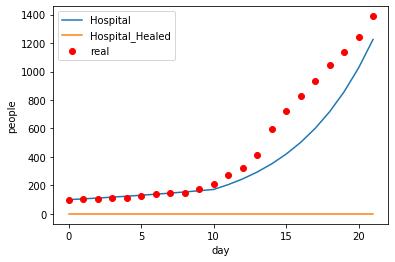

In [183]:
# step 2 day 8 to day 13
day_i = 11; day_f = 21
f_rate_s  = [0.1]
meeting_s = [10]                        
Rh_s      = np.arange(0.0001,0.0005,0.00005)
Rm_s      = np.arange(0.001,0.02,0.001)
Rr_s      = np.arange(0.01,0.06,0.005)
params, [MAE, CPop, CFRate] = fit(f_rate_s,meeting_s,Rh_s,Rm_s,Rr_s,day_i,day_f, CPop, CFRate)

In [ ]:
### prediction
day_i = 22 ; day_f = 300
use_last_fitting = True  # True or False
if use_last_fitting:
    ### from last fitting
    f_rate = params[1]
    meeting= params[2]
    Rh     = params[3]
    Rm     = params[4]
    Rr     = params[5]
else:
    ### new input
    f_rate = 0.5
    meeting= 7
    Rh     = 0.02
    Rm     = 0.1
    Rr     = 0.2

_,_ = model(f_rate, meeting, Rh, Rm, Rr, day_i, day_f, CPop, CFRate, plot=True, fit=False)

